In [2]:
#base imports
import time
import os
import keras
import tensorflow as tf
import util
#device imports
from keras import backend
if len(backend.tensorflow_backend._get_available_gpus()) > 0:
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.log_device_placement = True
    sess = tf.Session(config=config)
    set_session(sess)
    print("Using GPU")
else:   
    # Install the plaidml backend
    import plaidml.keras
    plaidml.keras.install_backend()
    os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
    print("Using Plaidml")

#Other imports
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.utils import *
from keras import Model,Sequential
from sklearn.metrics import classification_report
from keras.utils import np_utils


Using TensorFlow backend.






Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Using GPU


In [3]:
#load data
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
print("x_train shape:", trainX.shape, "y_train shape:", testX.shape)

x_train shape: (60000, 28, 28) y_train shape: (10000, 28, 28)


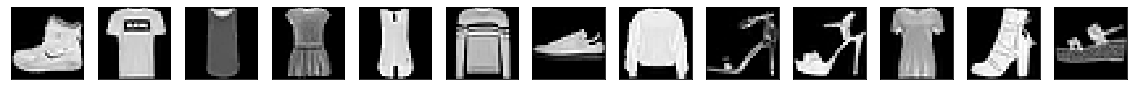

In [4]:
img_index=13
util.render_sample_data(trainX[:img_index])


In [5]:
#Normalize data
trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255
print(backend.image_data_format())
if backend.image_data_format() == "channels_first":
	trainX = trainX.reshape((trainX.shape[0], 1, 28, 28))
	testX = testX.reshape((testX.shape[0], 1, 28, 28))
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))

labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
trainY = np_utils.to_categorical(trainY, len(labelNames))
testY = np_utils.to_categorical(testY, len(labelNames))
print("x_train shape:", trainX.shape, "x_test shape:", testX.shape)
print("y_train shape:", trainY.shape, "t_test shape:", testY.shape)

channels_last
x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) t_test shape: (10000, 10)


In [0]:
#model
def build_model(width, height, depth, classes):
    # initialize the model along with the input shape to be
	# "channels last" and the channels dimension itself
	model = Sequential()
	inputShape = (height, width, depth)
	chanDim = -1
	# if we are using "channels first", update the input shape
	# and channels dimension
	if backend.image_data_format() == "channels_first":
	  inputShape = (depth, height, width)
	  chanDim = 1
    
  # first CONV => RELU => CONV => RELU => POOL layer set
	model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(32, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))

	# second CONV => RELU => CONV => RELU => POOL layer set
	model.add(Conv2D(64, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(64, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))

	# first (and only) set of FC => RELU layers
	model.add(Flatten())
	model.add(Dense(512))
	model.add(Activation("relu"))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))

	# softmax classifier
	model.add(Dense(classes))
	model.add(Activation("softmax"))

	# return the constructed network architecture
	return model

In [7]:
#variables
NUM_EPOCHS = 25
INIT_LR = 1e-2
BS = 32
#train and test
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model = build_model(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,metrics=["accuracy"])
print(model.summary())


[INFO] compiling model...






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2

In [10]:
# train the network
print("[INFO] training model...")
model_names="keras-fashion-mnist.h5"
callbacks=[
           ModelCheckpoint(model_names, monitor='acc', verbose=1, save_best_only=True,save_weights_only=False)
           ]
H = model.fit(trainX, trainY,
            validation_split=0.2,
	          batch_size=BS, 
            epochs=NUM_EPOCHS,
            shuffle=True,
            workers=2,
            use_multiprocessing=True,
            callbacks=callbacks)

[INFO] training model...
Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 17s 348us/step - loss: 0.2101 - acc: 0.9240 - val_loss: 0.1938 - val_acc: 0.9313

Epoch 00001: acc improved from -inf to 0.92396, saving model to keras-fashion-mnist.h5
Epoch 2/25
48000/48000 [==============================] - 17s 350us/step - loss: 0.2043 - acc: 0.9263 - val_loss: 0.2011 - val_acc: 0.9277

Epoch 00002: acc improved from 0.92396 to 0.92625, saving model to keras-fashion-mnist.h5
Epoch 3/25
48000/48000 [==============================] - 17s 348us/step - loss: 0.2036 - acc: 0.9265 - val_loss: 0.2010 - val_acc: 0.9276

Epoch 00003: acc improved from 0.92625 to 0.92648, saving model to keras-fashion-mnist.h5
Epoch 4/25
48000/48000 [==============================] - 17s 363us/step - loss: 0.1992 - acc: 0.9290 - val_loss: 0.1895 - val_acc: 0.9314

Epoch 00004: acc improved from 0.92648 to 0.92898, saving model to keras-fashion-mnist.h5
Epoch 5/

[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.89      0.88      0.88      1000
     trouser       1.00      0.98      0.99      1000
    pullover       0.93      0.88      0.91      1000
       dress       0.93      0.92      0.93      1000
        coat       0.87      0.92      0.89      1000
      sandal       0.99      0.99      0.99      1000
       shirt       0.78      0.80      0.79      1000
     sneaker       0.96      0.98      0.97      1000
         bag       0.99      0.99      0.99      1000
  ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



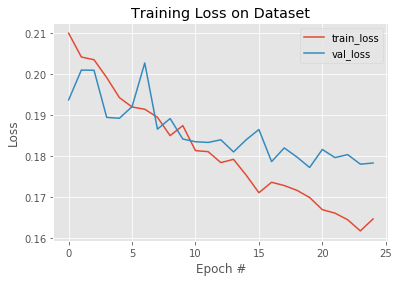

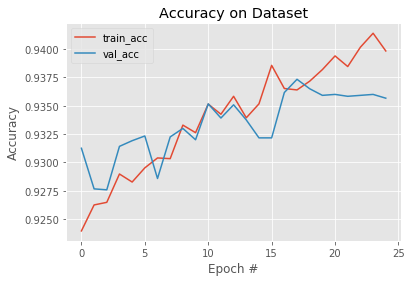

In [11]:
#test
preds = model.predict(testX) 
# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(testY.argmax(axis=1), preds.argmax(axis=1),target_names=labelNames))
 
# plot the training loss and accuracy

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")

plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_acc"], label="val_acc")
plt.title("Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")